In [58]:
import json
import os
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
from collections import defaultdict
import sys

# Import game functions for heuristic calculation
# Try to import from main.py (should be in same directory)
try:
    import main
    get_valid_moves = main.get_valid_moves
    count_discs = main.count_discs
    get_mobility = main.get_mobility
    count_stable_discs = main.count_stable_discs
    create_board = main.create_board
    apply_move = main.apply_move
    BOARD_SIZE = main.BOARD_SIZE
except ImportError:
    # Try adding current working directory to path
    sys.path.insert(0, str(Path.cwd()))
    try:
        import main
        get_valid_moves = main.get_valid_moves
        count_discs = main.count_discs
        get_mobility = main.get_mobility
        count_stable_discs = main.count_stable_discs
        create_board = main.create_board
        apply_move = main.apply_move
        BOARD_SIZE = main.BOARD_SIZE
    except ImportError:
        print("Warning: Could not import game functions from main.py")
        print("Heuristic calculation functions will not work without main.py")
        BOARD_SIZE = 8

In [59]:
# Configuration
DATA_DIR = "results/mcts-data"


# Analysis Functions

In [ ]:
def load_all_json_files(directory):
    """Load all JSON files from the specified directory."""
    data_files = []
    path = Path(directory)
    
    if not path.exists():
        print(f"Directory {directory} not found!")
        return data_files
    
    for file in path.glob("*.json"):
        try:
            with open(file, 'r') as f:
                data = json.load(f)
                data['filename'] = file.name
                data_files.append(data)
        except Exception as e:
            print(f"Error loading {file}: {e}")
    
    print(f"Loaded {len(data_files)} files")
    return data_files

def plot_win_rates(data_files):
    """Plot win rates across all games."""
    fig, ax = plt.subplots(figsize=(12, 6))
    
    filenames = [d['filename'] for d in data_files]
    black_wins = [d.get('summary', {}).get('black_win_rate', 0) for d in data_files]
    white_wins = [d.get('summary', {}).get('white_win_rate', 0) for d in data_files]
    draws = [d.get('summary', {}).get('draw_rate', 0) for d in data_files]
    
    x = np.arange(len(filenames))
    width = 0.25
    
    ax.bar(x - width, black_wins, width, label='Black Win Rate', color='black', alpha=0.7)
    ax.bar(x, white_wins, width, label='White Win Rate', color='white', edgecolor='black', alpha=0.7)
    ax.bar(x + width, draws, width, label='Draw Rate', color='gray', alpha=0.7)
    
    ax.set_xlabel('Game Files')
    ax.set_ylabel('Win Rate (%)')
    ax.set_title('Win Rates Across Different Games')
    ax.set_xticks(x)
    ax.set_xticklabels(filenames, rotation=45, ha='right')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

def plot_score_comparison(data_files):
    """Plot average scores for black and white players."""
    fig, ax = plt.subplots(figsize=(12, 6))
    
    filenames = [d['filename'] for d in data_files]
    black_scores = [d.get('summary', {}).get('avg_black_score', 0) for d in data_files]
    white_scores = [d.get('summary', {}).get('avg_white_score', 0) for d in data_files]
    
    x = np.arange(len(filenames))
    width = 0.35
    
    ax.bar(x - width/2, black_scores, width, label='Black Avg Score', color='black', alpha=0.7)
    ax.bar(x + width/2, white_scores, width, label='White Avg Score', color='lightgray', edgecolor='black', alpha=0.7)
    
    ax.set_xlabel('Game Files')
    ax.set_ylabel('Average Score')
    ax.set_title('Average Scores: Black vs White')
    ax.set_xticks(x)
    ax.set_xticklabels(filenames, rotation=45, ha='right')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

def plot_game_length(data_files):
    """Plot average game length (total moves)."""
    fig, ax = plt.subplots(figsize=(12, 6))
    
    filenames = [d['filename'] for d in data_files]
    avg_moves = [d.get('summary', {}).get('avg_total_moves', 0) for d in data_files]
    
    ax.bar(range(len(filenames)), avg_moves, color='steelblue', alpha=0.7)
    ax.set_xlabel('Game Files')
    ax.set_ylabel('Average Total Moves')
    ax.set_title('Average Game Length')
    ax.set_xticks(range(len(filenames)))
    ax.set_xticklabels(filenames, rotation=45, ha='right')
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

def plot_memory_usage(data_files):
    """Plot memory usage statistics."""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    filenames = [d['filename'] for d in data_files]
    avg_memory = [d.get('summary', {}).get('avg_memory_usage_mb', 0) for d in data_files]
    peak_memory = [d.get('summary', {}).get('peak_memory_usage_mb', 0) for d in data_files]
    
    # Average memory usage
    ax1.bar(range(len(filenames)), avg_memory, color='green', alpha=0.7)
    ax1.set_xlabel('Game Files')
    ax1.set_ylabel('Memory (MB)')
    ax1.set_title('Average Memory Usage')
    ax1.set_xticks(range(len(filenames)))
    ax1.set_xticklabels(filenames, rotation=45, ha='right')
    ax1.grid(True, alpha=0.3)
    
    # Peak memory usage
    ax2.bar(range(len(filenames)), peak_memory, color='red', alpha=0.7)
    ax2.set_xlabel('Game Files')
    ax2.set_ylabel('Memory (MB)')
    ax2.set_title('Peak Memory Usage')
    ax2.set_xticks(range(len(filenames)))
    ax2.set_xticklabels(filenames, rotation=45, ha='right')
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

def plot_time_per_game(data_files):
    """Plot average time per game."""
    fig, ax = plt.subplots(figsize=(12, 6))
    
    filenames = [d['filename'] for d in data_files]
    avg_time = [d.get('summary', {}).get('avg_time_per_game', 0) for d in data_files]
    
    ax.bar(range(len(filenames)), avg_time, color='purple', alpha=0.7)
    ax.set_xlabel('Game Files')
    ax.set_ylabel('Time (seconds)')
    ax.set_title('Average Time Per Game')
    ax.set_xticks(range(len(filenames)))
    ax.set_xticklabels(filenames, rotation=45, ha='right')
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

def plot_move_time_comparison(data_files):
    """Plot average move times for black and white players."""
    # Check if any file has move time data
    has_timing_data = any(d.get('summary', {}).get('avg_move_time_black') is not None 
                          for d in data_files)
    
    if not has_timing_data:
        print("No move timing data found in files")
        return
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    filenames = [d['filename'] for d in data_files]
    black_avg = [d.get('summary', {}).get('avg_move_time_black', 0) for d in data_files]
    white_avg = [d.get('summary', {}).get('avg_move_time_white', 0) for d in data_files]
    black_max = [d.get('summary', {}).get('max_move_time_black', 0) for d in data_files]
    white_max = [d.get('summary', {}).get('max_move_time_white', 0) for d in data_files]
    
    x = np.arange(len(filenames))
    width = 0.35
    
    # Average move times
    ax1.bar(x - width/2, black_avg, width, label='Black Avg', color='black', alpha=0.7)
    ax1.bar(x + width/2, white_avg, width, label='White Avg', color='lightgray', edgecolor='black', alpha=0.7)
    ax1.set_xlabel('Game Files')
    ax1.set_ylabel('Time (seconds)')
    ax1.set_title('Average Move Time per Player')
    ax1.set_xticks(x)
    ax1.set_xticklabels(filenames, rotation=45, ha='right')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Max move times
    ax2.bar(x - width/2, black_max, width, label='Black Max', color='black', alpha=0.7)
    ax2.bar(x + width/2, white_max, width, label='White Max', color='lightgray', edgecolor='black', alpha=0.7)
    ax2.set_xlabel('Game Files')
    ax2.set_ylabel('Time (seconds)')
    ax2.set_title('Maximum Move Time per Player')
    ax2.set_xticks(x)
    ax2.set_xticklabels(filenames, rotation=45, ha='right')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

def plot_timing_by_game_phase(data_files):
    """Plot timing statistics by game phase (early/mid/late game)."""
    # Check if any file has game phase timing data
    has_phase_data = any(d.get('summary', {}).get('timing_by_game_phase') is not None 
                         for d in data_files)
    
    if not has_phase_data:
        print("No game phase timing data found in files")
        return
    
    # Aggregate data across all files
    phases = ['early_game', 'mid_game', 'late_game']
    avg_times = []
    max_times = []
    min_times = []
    
    for phase in phases:
        phase_avg = []
        phase_max = []
        phase_min = []
        
        for data in data_files:
            phase_data = data.get('summary', {}).get('timing_by_game_phase', {}).get(phase, {})
            if phase_data:
                phase_avg.append(phase_data.get('avg_time', 0))
                phase_max.append(phase_data.get('max_time', 0))
                phase_min.append(phase_data.get('min_time', 0))
        
        avg_times.append(np.mean(phase_avg) if phase_avg else 0)
        max_times.append(np.mean(phase_max) if phase_max else 0)
        min_times.append(np.mean(phase_min) if phase_min else 0)
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    x = np.arange(len(phases))
    
    # Average times by phase
    ax1.bar(x, avg_times, color=['#1f77b4', '#ff7f0e', '#2ca02c'], alpha=0.7)
    ax1.set_xlabel('Game Phase')
    ax1.set_ylabel('Average Time (seconds)')
    ax1.set_title('Average Move Time by Game Phase')
    ax1.set_xticks(x)
    ax1.set_xticklabels(['Early Game', 'Mid Game', 'Late Game'])
    ax1.grid(True, alpha=0.3)
    
    # Min/Max times by phase
    width = 0.35
    ax2.bar(x - width/2, max_times, width, label='Max Time', color='red', alpha=0.7)
    ax2.bar(x + width/2, min_times, width, label='Min Time', color='blue', alpha=0.7)
    ax2.set_xlabel('Game Phase')
    ax2.set_ylabel('Time (seconds)')
    ax2.set_title('Min/Max Move Times by Game Phase')
    ax2.set_xticks(x)
    ax2.set_xticklabels(['Early Game', 'Mid Game', 'Late Game'])
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

def plot_timing_by_board_fill(data_files):
    """Plot timing statistics by board fill percentage."""
    # Check if any file has board fill timing data
    has_fill_data = any(d.get('summary', {}).get('timing_by_board_fill') is not None 
                        for d in data_files)
    
    if not has_fill_data:
        print("No board fill timing data found in files")
        return
    
    # Aggregate data across all files
    fill_stages = ['early', 'mid', 'late']
    avg_times = []
    max_times = []
    move_counts = []
    
    for stage in fill_stages:
        stage_avg = []
        stage_max = []
        stage_moves = []
        
        for data in data_files:
            fill_data = data.get('summary', {}).get('timing_by_board_fill', {}).get(stage, {})
            if fill_data:
                stage_avg.append(fill_data.get('avg_time', 0))
                stage_max.append(fill_data.get('max_time', 0))
                stage_moves.append(fill_data.get('move_count', 0))
        
        avg_times.append(np.mean(stage_avg) if stage_avg else 0)
        max_times.append(np.mean(stage_max) if stage_max else 0)
        move_counts.append(np.sum(stage_moves) if stage_moves else 0)
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    x = np.arange(len(fill_stages))
    
    # Average times by board fill
    ax1.bar(x, avg_times, color=['#d62728', '#9467bd', '#8c564b'], alpha=0.7)
    ax1.set_xlabel('Board Fill Stage')
    ax1.set_ylabel('Average Time (seconds)')
    ax1.set_title('Average Move Time by Board Fill Percentage')
    ax1.set_xticks(x)
    ax1.set_xticklabels(['Early (0-33%)', 'Mid (33-66%)', 'Late (66-100%)'])
    ax1.grid(True, alpha=0.3)
    
    # Move count distribution
    ax2.bar(x, move_counts, color=['#d62728', '#9467bd', '#8c564b'], alpha=0.7)
    ax2.set_xlabel('Board Fill Stage')
    ax2.set_ylabel('Total Move Count')
    ax2.set_title('Move Distribution by Board Fill Percentage')
    ax2.set_xticks(x)
    ax2.set_xticklabels(['Early (0-33%)', 'Mid (33-66%)', 'Late (66-100%)'])
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

def plot_combined_timing_heatmap(data_files):
    """Create a heatmap showing timing patterns across all files."""
    has_phase_data = any(d.get('summary', {}).get('timing_by_game_phase') is not None 
                         for d in data_files)
    
    if not has_phase_data:
        print("No timing data for heatmap")
        return
    
    filenames = []
    phases = ['early_game', 'mid_game', 'late_game']
    timing_matrix = []
    
    for data in data_files:
        phase_timing = data.get('summary', {}).get('timing_by_game_phase', {})
        if phase_timing:
            filenames.append(data['filename'][:25])
            row = [phase_timing.get(phase, {}).get('avg_time', 0) for phase in phases]
            timing_matrix.append(row)
    
    if not timing_matrix:
        print("No timing data available for heatmap")
        return
    
    fig, ax = plt.subplots(figsize=(10, max(6, len(filenames) * 0.4)))
    
    im = ax.imshow(timing_matrix, cmap='YlOrRd', aspect='auto')
    
    ax.set_xticks(np.arange(len(phases)))
    ax.set_yticks(np.arange(len(filenames)))
    ax.set_xticklabels(['Early Game', 'Mid Game', 'Late Game'])
    ax.set_yticklabels(filenames)
    
    # Add colorbar
    cbar = plt.colorbar(im, ax=ax)
    cbar.set_label('Average Time (seconds)', rotation=270, labelpad=20)
    
    # Add text annotations
    for i in range(len(filenames)):
        for j in range(len(phases)):
            text = ax.text(j, i, f'{timing_matrix[i][j]:.3f}',
                          ha="center", va="center", color="black", fontsize=8)
    
    ax.set_title('Move Time Heatmap by Game Phase')
    plt.tight_layout()
    plt.show()

def plot_agent_comparison(data_files):
    """Group results by agent configuration and compare performance."""
    agent_stats = defaultdict(lambda: {'black_wins': [], 'white_wins': [], 'draws': []})
    
    for data in data_files:
        config = data.get('config', {})
        agents = config.get('agents', [])
        agent_key = str(agents)
        
        agent_stats[agent_key]['black_wins'].append(data.get('black_wins', 0))
        agent_stats[agent_key]['white_wins'].append(data.get('white_wins', 0))
        agent_stats[agent_key]['draws'].append(data.get('draws', 0))
    
    if not agent_stats:
        print("No agent configuration data found")
        return
    
    fig, ax = plt.subplots(figsize=(14, 6))
    
    agent_names = list(agent_stats.keys())
    black_totals = [sum(agent_stats[name]['black_wins']) for name in agent_names]
    white_totals = [sum(agent_stats[name]['white_wins']) for name in agent_names]
    draw_totals = [sum(agent_stats[name]['draws']) for name in agent_names]
    
    x = np.arange(len(agent_names))
    width = 0.25
    
    ax.bar(x - width, black_totals, width, label='Black Wins', color='black', alpha=0.7)
    ax.bar(x, white_totals, width, label='White Wins', color='white', edgecolor='black', alpha=0.7)
    ax.bar(x + width, draw_totals, width, label='Draws', color='gray', alpha=0.7)
    
    ax.set_xlabel('Agent Configuration')
    ax.set_ylabel('Total Wins')
    ax.set_title('Performance by Agent Configuration')
    ax.set_xticks(x)
    ax.set_xticklabels([f"Config {i+1}" for i in range(len(agent_names))], rotation=45, ha='right')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

def create_summary_table(data_files):
    """Create a summary table of all data."""
    print("\n" + "="*120)
    print("SUMMARY TABLE")
    print("="*120)
    print(f"{'Filename':<30} {'Games':<8} {'Black%':<8} {'White%':<8} {'Draws%':<8} {'Avg Moves':<10} {'Avg Time':<10} {'B Move':<10} {'W Move':<10}")
    print("-"*120)
    
    for data in data_files:
        filename = data['filename'][:28]
        num_games = data.get('num_games', 0)
        summary = data.get('summary', {})
        black_wr = summary.get('black_win_rate', 0)
        white_wr = summary.get('white_win_rate', 0)
        draw_rate = summary.get('draw_rate', 0)
        avg_moves = summary.get('avg_total_moves', 0)
        avg_time = summary.get('avg_time_per_game', 0)
        black_move_time = summary.get('avg_move_time_black', 0)
        white_move_time = summary.get('avg_move_time_white', 0)
        
        print(f"{filename:<30} {num_games:<8} {black_wr:<8.1f} {white_wr:<8.1f} {draw_rate:<8.1f} "
              f"{avg_moves:<10.1f} {avg_time:<10.2f} {black_move_time:<10.3f} {white_move_time:<10.3f}")
    
    print("="*120)

def get_agent_label(agent_config):
    """Convert agent configuration to a readable label."""
    if not agent_config or len(agent_config) == 0:
        return "unknown"
    
    agent_type = agent_config[0]
    
    if agent_type == "minimax":
        use_alpha_beta = agent_config[1] if len(agent_config) > 1 else False
        depth = agent_config[2] if len(agent_config) > 2 else "?"
        ab_str = "αβ" if use_alpha_beta else "no-αβ"
        return f"minimax-{ab_str}-d{depth}"
    elif agent_type == "mcts":
        iterations = agent_config[1] if len(agent_config) > 1 else "?"
        rollout_type = agent_config[2] if len(agent_config) > 2 else "?"
        rollout_depth = agent_config[3] if len(agent_config) > 3 else "?"
        return f"mcts-{iterations}-r-{rollout_depth}"
    else:
        return str(agent_type)

def plot_move_time_over_game(data_files):
    """
    Plot move time over the course of a game as a line graph.
    Compares minimax and different MCTS agent configurations.
    """
    # Check if move_times_by_position data exists
    has_data = any(d.get('move_times_by_position') is not None for d in data_files)
    
    if not has_data:
        print("No move_times_by_position data found in files")
        return
    
    # Group data by agent configuration
    agent_data = defaultdict(lambda: defaultdict(list))  # agent_label -> move_number -> [times]
    
    for data in data_files:
        config = data.get('config', {})
        agents = config.get('agents', [])
        
        if len(agents) < 2:
            continue
        
        black_agent = agents[0]
        white_agent = agents[1]
        black_label = get_agent_label(black_agent)
        white_label = get_agent_label(white_agent)
        
        move_times_by_pos = data.get('move_times_by_position', [])
        
        if not move_times_by_pos:
            continue
        
        # Process each move
        for move_data in move_times_by_pos:
            move_number = move_data.get('move_number', 0)
            player = move_data.get('player', '')
            time_seconds = move_data.get('time_seconds', 0)
            
            if move_number == 0:  # Skip initial board state
                continue
            
            # Assign to appropriate agent
            if player == 'black':
                agent_data[black_label][move_number].append(time_seconds)
            elif player == 'white':
                agent_data[white_label][move_number].append(time_seconds)
    
    if not agent_data:
        print("No agent timing data found")
        return
    
    # Calculate average times per move number for each agent
    agent_avg_times = {}
    max_move_number = 0
    
    for agent_label, move_times_dict in agent_data.items():
        avg_times = {}
        for move_num, times in move_times_dict.items():
            if times:
                avg_times[move_num] = np.mean(times)
                max_move_number = max(max_move_number, move_num)
        agent_avg_times[agent_label] = avg_times
    
    # Create the plot
    fig, ax = plt.subplots(figsize=(14, 8))
    
    # Define colors for different agent types
    # Use a more flexible color assignment
    color_map = {
        'minimax': '#1f77b4',  # Blue
        'mcts-100-r-1': '#ff7f0e',  # Orange
        'mcts-100-r-5': '#2ca02c',  # Green
        'mcts-100-r-10': '#d62728',  # Red
        'mcts-1000-r-1': '#9467bd',  # Purple
    }
    
    # Additional colors for any other agents
    default_colors = ['#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
    color_idx = 0
    
    # Plot each agent
    for agent_label in sorted(agent_avg_times.keys()):
        avg_times = agent_avg_times[agent_label]
        move_numbers = sorted(avg_times.keys())
        times = [avg_times[m] for m in move_numbers]
        
        # Get color - try exact match first, then check if label starts with key (for minimax variants)
        color = None
        # First try exact match
        if agent_label in color_map:
            color = color_map[agent_label]
        else:
            # For partial matches (mainly for minimax variants like "minimax-αβ-d4")
            for key, val in color_map.items():
                if agent_label.startswith(key + '-') or agent_label == key:
                    color = val
                    break
        
        # If no match found, use default color cycle
        if not color:
            color = default_colors[color_idx % len(default_colors)]
            color_idx += 1
        
        # Simplify label for display (remove minimax depth details, keep MCTS config)
        display_label = agent_label
        if agent_label.startswith('minimax'):
            display_label = 'minimax'
        elif 'mcts' in agent_label:
            # Keep the full MCTS config (e.g., mcts-100-r-5, mcts-100-r-10, mcts-1000-r-1)
            pass
        
        ax.plot(move_numbers, times, marker='o', label=display_label, 
                linewidth=2, markersize=4, alpha=0.7, color=color)
    
    ax.set_xlabel('Move Number', fontsize=12)
    ax.set_ylabel('Average Move Time (seconds)', fontsize=12)
    ax.set_title('Move Time Over the Course of a Game\n(Comparing Minimax and MCTS Agents)', fontsize=14, fontweight='bold')
    ax.legend(loc='best', fontsize=10)
    ax.grid(True, alpha=0.3)
    ax.set_xlim(left=1)
    
    plt.tight_layout()
    plt.show()

def plot_win_percentages_by_configuration(data_files):
    """
    Plot win percentages between agent configurations.
    Shows which agent is MCTS (with hyperparameters), which is minimax, and which played first (black).
    """
    if not data_files:
        print("No data files provided")
        return
    
    # Collect matchup data
    matchups = []
    
    for data in data_files:
        config = data.get('config', {})
        agents = config.get('agents', [])
        
        if len(agents) < 2:
            continue
        
        black_agent = agents[0]
        white_agent = agents[1]
        black_label = get_agent_label(black_agent)
        white_label = get_agent_label(white_agent)
        
        # Get win rates
        black_wins = data.get('black_wins', 0)
        white_wins = data.get('white_wins', 0)
        draws = data.get('draws', 0)
        num_games = black_wins + white_wins + draws
        
        if num_games == 0:
            continue
        
        # Calculate percentages
        black_win_pct = (black_wins / num_games) * 100
        white_win_pct = (white_wins / num_games) * 100
        draw_pct = (draws / num_games) * 100
        
        # Determine agent types
        black_type = "MCTS" if black_label.startswith("mcts") else "Minimax"
        white_type = "MCTS" if white_label.startswith("mcts") else "Minimax"
        
        # Create matchup label
        matchup_label = f"{black_label} (Black, {black_type}) vs {white_label} (White, {white_type})"
        
        matchups.append({
            'label': matchup_label,
            'black_label': black_label,
            'white_label': white_label,
            'black_type': black_type,
            'white_type': white_type,
            'black_win_pct': black_win_pct,
            'white_win_pct': white_win_pct,
            'draw_pct': draw_pct,
            'num_games': num_games
        })
    
    if not matchups:
        print("No matchup data found")
        return
    
    # Create the plot
    fig, ax = plt.subplots(figsize=(16, max(8, len(matchups) * 0.8)))
    
    y_pos = np.arange(len(matchups))
    width = 0.25
    
    # Prepare data for grouped bars
    black_win_pcts = [m['black_win_pct'] for m in matchups]
    white_win_pcts = [m['white_win_pct'] for m in matchups]
    draw_pcts = [m['draw_pct'] for m in matchups]
    
    # Create bars
    bars1 = ax.barh(y_pos - width, black_win_pcts, width, 
                    label='Black Wins', color='#2c3e50', alpha=0.8)
    bars2 = ax.barh(y_pos, white_win_pcts, width, 
                    label='White Wins', color='#ecf0f1', edgecolor='#2c3e50', linewidth=1.5, alpha=0.8)
    bars3 = ax.barh(y_pos + width, draw_pcts, width, 
                    label='Draws', color='#95a5a6', alpha=0.8)
    
    # Add value labels on bars
    def add_value_labels(bars, values):
        for i, (bar, val) in enumerate(zip(bars, values)):
            if val > 0:  # Only label if value is greater than 0
                width_bar = bar.get_width()
                ax.text(width_bar / 2, bar.get_y() + bar.get_height() / 2,
                       f'{val:.1f}%', ha='center', va='center', 
                       fontweight='bold', fontsize=9)
    
    add_value_labels(bars1, black_win_pcts)
    add_value_labels(bars2, white_win_pcts)
    add_value_labels(bars3, draw_pcts)
    
    # Create detailed labels showing agent info
    detailed_labels = []
    for m in matchups:
        # Format: "Black: [agent] | White: [agent]"
        black_display = m['black_label']
        white_display = m['white_label']
        
        # Simplify minimax labels
        if black_display.startswith('minimax'):
            black_display = 'minimax'
        if white_display.startswith('minimax'):
            white_display = 'minimax'
        
        label = f"Black: {black_display} ({m['black_type']}) | White: {white_display} ({m['white_type']})"
        detailed_labels.append(label)
    
    ax.set_yticks(y_pos)
    ax.set_yticklabels(detailed_labels, fontsize=10)
    ax.set_xlabel('Win Percentage (%)', fontsize=12)
    ax.set_title('Win Percentages by Agent Configuration\n(Showing MCTS hyperparameters, Minimax, and who played first)', 
                 fontsize=14, fontweight='bold', pad=20)
    ax.legend(loc='lower right', fontsize=10)
    ax.grid(True, alpha=0.3, axis='x')
    ax.set_xlim(0, 100)
    
    # Add a note about first player
    ax.text(0.02, 0.98, 'Note: Black plays first', transform=ax.transAxes,
            fontsize=9, verticalalignment='top', 
            bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
    
    plt.tight_layout()
    plt.show()

def calculate_heuristic_score(board, player, weights=None):
    """
    Calculate heuristic score for a board state using the same logic as MinimaxAgent.
    Uses weights from MinimaxAgent (defined in agent.py).
    
    Args:
        board: Board state as numpy array or list of lists
        player: Player to evaluate for (1 for white, -1 for black)
        weights: Optional dict of weights. If None, uses MinimaxAgent defaults.
    
    Returns:
        Heuristic score from player's perspective
    """
    # Convert board to numpy array if needed
    if isinstance(board, list):
        board = np.array(board)
    
    # Use weights from MinimaxAgent (from agent.py)
    if weights is None:
        weights = {
            'corner': 25,      # Corner control is very important
            'edge': 5,         # Edge control is valuable
            'mobility': 10,    # Mobility (move options) is important
            'stability': 15,   # Stable discs are valuable
            'disc_count': 1,   # Disc count matters, especially in endgame
        }
    
    opponent = -player
    whites, blacks = count_discs(board)
    total_discs = whites + blacks
    
    # Corner control
    corners = [(0, 0), (0, 7), (7, 0), (7, 7)]
    player_corners = sum(1 for r, c in corners if board[r][c] == player)
    opponent_corners = sum(1 for r, c in corners if board[r][c] == opponent)
    corner_score = weights['corner'] * (player_corners - opponent_corners)
    
    # Edge control (excluding corners)
    edge_positions = []
    for r in range(BOARD_SIZE):
        if r == 0 or r == 7:
            for c in range(1, 7):  # Exclude corners
                edge_positions.append((r, c))
        else:
            edge_positions.append((r, 0))
            edge_positions.append((r, 7))
    
    player_edges = sum(1 for r, c in edge_positions if board[r][c] == player)
    opponent_edges = sum(1 for r, c in edge_positions if board[r][c] == opponent)
    edge_score = weights['edge'] * (player_edges - opponent_edges)
    
    # Mobility
    player_mobility = get_mobility(board, player)
    opponent_mobility = get_mobility(board, opponent)
    mobility_score = weights['mobility'] * (player_mobility - opponent_mobility)
    
    # Stability (only compute after 20 discs for performance)
    if total_discs > 20:
        player_stable = count_stable_discs(board, player)
        opponent_stable = count_stable_discs(board, opponent)
        stability_score = weights['stability'] * (player_stable - opponent_stable)
    else:
        stability_score = 0
    
    # Disc count (weighted by game progress)
    if player == 1:  # White
        disc_diff = whites - blacks
    else:  # Black
        disc_diff = blacks - whites
    
    # Weight disc count more heavily in endgame
    endgame_weight = weights['disc_count'] * (total_discs / 64.0)
    disc_score = endgame_weight * disc_diff
    
    # Combine all heuristics
    total_score = corner_score + edge_score + mobility_score + stability_score + disc_score
    
    return total_score

def plot_heuristic_scores_over_game(data_files, replay_dir=None, separate_by_minimax_result=False):
    """
    Plot heuristic scores over the course of a game for each agent configuration.
    Uses heuristics from main.py and weights from MinimaxAgent (agent.py).
    
    Args:
        data_files: List of data file dictionaries (summary files)
        replay_dir: Optional directory containing replay files with board states.
                   If None, will search in 'replays/' and subdirectories.
        separate_by_minimax_result: If True, separate games by whether minimax won or lost.
    """
    # Check if we can get board states from replay files
    if replay_dir is None:
        # Try to find replay directory - check root/replays and subdirectories
        possible_dirs = ['replays', '../replays', './replays']
        replay_dir = None
        for dir_path in possible_dirs:
            if Path(dir_path).exists():
                replay_dir = dir_path
                break
    
    if replay_dir is None:
        print("Warning: Could not find 'replays' directory.")
        print("Please specify replay_dir parameter or ensure 'replays' directory exists.")
        return
    
    # Group data by agent configuration and optionally by minimax win/loss
    if separate_by_minimax_result:
        # Structure: agent_label -> 'minimax_won'/'minimax_lost' -> move_number -> [scores]
        agent_data = defaultdict(lambda: defaultdict(lambda: defaultdict(list)))
    else:
        # Structure: agent_label -> move_number -> [scores]
        agent_data = defaultdict(lambda: defaultdict(list))
    
    # Try to load replay files that match the data files
    replay_files_processed = 0
    replay_path = Path(replay_dir)
    
    if not replay_path.exists():
        print(f"Warning: Replay directory '{replay_dir}' does not exist.")
        return
    
    for data in data_files:
        filename = data.get('filename', '')
        # Try to find matching replay file
        # Match by agent configuration rather than exact filename
        config = data.get('config', {})
        agents = config.get('agents', [])
        
        if len(agents) < 2:
            continue
        
        # Determine which agent is minimax
        black_agent = agents[0]
        white_agent = agents[1]
        black_label = get_agent_label(black_agent)
        white_label = get_agent_label(white_agent)
        
        is_minimax_black = black_label.startswith('minimax')
        is_minimax_white = white_label.startswith('minimax')
        
        # Look for replay files in replays/ and subdirectories (e.g., replays/mcts-...)
        # Search recursively in all subdirectories
        replay_files = list(replay_path.rglob("*.json"))
        
        for replay_file in replay_files:
            try:
                with open(replay_file, 'r') as f:
                    replay_data = json.load(f)
                
                replay_config = replay_data.get('config', {})
                replay_agents = replay_config.get('agents', [])
                
                # Check if agents match
                if (len(replay_agents) == 2 and 
                    str(replay_agents[0]) == str(agents[0]) and 
                    str(replay_agents[1]) == str(agents[1])):
                    
                    # Determine game result
                    result = replay_data.get('result', {})
                    winner = result.get('winner', '')
                    winner_player = result.get('winner_player', None)
                    
                    # Determine if minimax won
                    minimax_won = False
                    if separate_by_minimax_result:
                        if is_minimax_black:
                            # Minimax is black (-1)
                            minimax_won = (winner_player == -1) or (winner == 'Black')
                        elif is_minimax_white:
                            # Minimax is white (1)
                            minimax_won = (winner_player == 1) or (winner == 'White')
                        else:
                            # No minimax in this game, skip separation
                            minimax_won = None
                    
                    moves = replay_data.get('moves', [])
                    
                    # Calculate heuristic scores for each move
                    for move_data in moves:
                        move_number = move_data.get('move_number', 0)
                        if move_number == 0:
                            continue
                        
                        # Get board state (prefer board_after if available)
                        board = None
                        if 'board_after' in move_data:
                            board = np.array(move_data['board_after'])
                        elif 'board' in move_data:
                            board = np.array(move_data['board'])
                        
                        if board is None:
                            continue
                        
                        player_str = move_data.get('player', '')
                        
                        # Calculate heuristic for both players at this state
                        # Evaluate from the perspective of the player who just moved
                        if player_str == 'black':
                            # Black just moved, evaluate from black's perspective
                            score = calculate_heuristic_score(board, -1)
                            
                            if separate_by_minimax_result and minimax_won is not None:
                                result_key = 'minimax_won' if minimax_won else 'minimax_lost'
                                agent_data[black_label][result_key][move_number].append(score)
                            else:
                                agent_data[black_label][move_number].append(score)
                                
                        elif player_str == 'white':
                            # White just moved, evaluate from white's perspective
                            score = calculate_heuristic_score(board, 1)
                            
                            if separate_by_minimax_result and minimax_won is not None:
                                result_key = 'minimax_won' if minimax_won else 'minimax_lost'
                                agent_data[white_label][result_key][move_number].append(score)
                            else:
                                agent_data[white_label][move_number].append(score)
                    
                    replay_files_processed += 1
                    break  # Found a match, move to next data file
            
            except Exception as e:
                continue
    
    # If no replay files found, try to reconstruct from move_times_by_position
    # (This is limited since we don't have actual moves, but we can estimate)
    if replay_files_processed == 0:
        print("Warning: No replay files found with board states.")
        print("Heuristic scores require board states. Please provide replay files or ensure replay_dir is set correctly.")
        return
    
    if not agent_data:
        print("No heuristic data collected")
        return
    
    # Create the plot
    fig, ax = plt.subplots(figsize=(14, 8))
    
    # Define colors for different agent types (same as move time plot)
    color_map = {
        'minimax': '#1f77b4',  # Blue
        'mcts-100-r-1': '#ff7f0e',  # Orange
        'mcts-100-r-5': '#2ca02c',  # Green
        'mcts-100-r-10': '#d62728',  # Red
        'mcts-1000-r-1': '#9467bd',  # Purple
    }
    
    default_colors = ['#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
    color_idx = 0
    max_move_number = 0
    
    if separate_by_minimax_result:
        # Handle separated data structure
        # Track which agents we've added to legend to avoid duplicates
        agents_in_legend = set()
        
        for agent_label in sorted(agent_data.keys()):
            agent_result_data = agent_data[agent_label]
            
            # Get base color for agent
            base_color = None
            if agent_label in color_map:
                base_color = color_map[agent_label]
            else:
                for key, val in color_map.items():
                    if agent_label.startswith(key + '-') or agent_label == key:
                        base_color = val
                        break
            
            if not base_color:
                base_color = default_colors[color_idx % len(default_colors)]
                color_idx += 1
            
            # Simplify label for display
            display_label_base = agent_label
            if agent_label.startswith('minimax'):
                display_label_base = 'minimax'
            elif 'mcts' in agent_label:
                pass  # Keep full MCTS config
            
            # Plot for minimax wins (solid line)
            if 'minimax_won' in agent_result_data:
                move_scores_dict = agent_result_data['minimax_won']
                avg_scores = {}
                for move_num, scores in move_scores_dict.items():
                    if scores:
                        avg_scores[move_num] = np.mean(scores)
                        max_move_number = max(max_move_number, move_num)
                
                if avg_scores:
                    move_numbers = sorted(avg_scores.keys())
                    scores = [avg_scores[m] for m in move_numbers]
                    # Only add label if this agent hasn't been added yet
                    label = display_label_base if display_label_base not in agents_in_legend else ''
                    if display_label_base not in agents_in_legend:
                        agents_in_legend.add(display_label_base)
                    ax.plot(move_numbers, scores, marker='o', 
                           label=label, 
                           linewidth=2, markersize=4, alpha=0.7, 
                           color=base_color, linestyle='-')
            
            # Plot for minimax losses (dashed line)
            if 'minimax_lost' in agent_result_data:
                move_scores_dict = agent_result_data['minimax_lost']
                avg_scores = {}
                for move_num, scores in move_scores_dict.items():
                    if scores:
                        avg_scores[move_num] = np.mean(scores)
                        max_move_number = max(max_move_number, move_num)
                
                if avg_scores:
                    move_numbers = sorted(avg_scores.keys())
                    scores = [avg_scores[m] for m in move_numbers]
                    # Don't add label for dashed lines (already in legend)
                    ax.plot(move_numbers, scores, marker='s', 
                           label='',  # No label - line style indicates win/loss
                           linewidth=2, markersize=4, alpha=0.5, 
                           color=base_color, linestyle='--')
        
        # Add line style explanation to legend
        from matplotlib.lines import Line2D
        legend_elements = [
            Line2D([0], [0], color='gray', linestyle='-', linewidth=2, label='Minimax Won'),
            Line2D([0], [0], color='gray', linestyle='--', linewidth=2, label='Minimax Lost')
        ]
        
        title_suffix = '\n(Solid = Minimax Won, Dashed = Minimax Lost)'
    else:
        # Handle normal data structure
        agent_avg_scores = {}
        
        for agent_label, move_scores_dict in agent_data.items():
            avg_scores = {}
            for move_num, scores in move_scores_dict.items():
                if scores:
                    avg_scores[move_num] = np.mean(scores)
                    max_move_number = max(max_move_number, move_num)
            agent_avg_scores[agent_label] = avg_scores
        
        # Plot each agent
        for agent_label in sorted(agent_avg_scores.keys()):
            avg_scores = agent_avg_scores[agent_label]
            move_numbers = sorted(avg_scores.keys())
            scores = [avg_scores[m] for m in move_numbers]
            
            # Get color
            color = None
            if agent_label in color_map:
                color = color_map[agent_label]
            else:
                for key, val in color_map.items():
                    if agent_label.startswith(key + '-') or agent_label == key:
                        color = val
                        break
            
            if not color:
                color = default_colors[color_idx % len(default_colors)]
                color_idx += 1
            
            # Simplify label for display
            display_label = agent_label
            if agent_label.startswith('minimax'):
                display_label = 'minimax'
            elif 'mcts' in agent_label:
                pass  # Keep full MCTS config
            
            ax.plot(move_numbers, scores, marker='o', label=display_label, 
                    linewidth=2, markersize=4, alpha=0.7, color=color)
        
        title_suffix = ''
    
    ax.set_xlabel('Move Number', fontsize=12)
    ax.set_ylabel('Heuristic Score', fontsize=12)
    ax.set_title('Heuristic Score Over the Course of a Game\n(Using weights from MinimaxAgent)' + title_suffix, 
                 fontsize=14, fontweight='bold')
    ax.legend(loc='best', fontsize=10)
    ax.grid(True, alpha=0.3)
    ax.set_xlim(left=1)
    ax.axhline(y=0, color='gray', linestyle='--', alpha=0.5, linewidth=1)
    
    plt.tight_layout()
    plt.show()

# The Fun Stuff

Loading data from: results/mcts-data
Loaded 9 files

SUMMARY TABLE
Filename                       Games    Black%   White%   Draws%   Avg Moves  Avg Time   B Move     W Move    
------------------------------------------------------------------------------------------------------------------------
mcts-100-r-1-vs-minimax.json   100      15.0     85.0     0.0      30.0       28.53      0.761      0.194     
mcts-100-r-10-vs-minimax-alt   100      37.0     63.0     0.0      30.0       213.65     6.949      0.195     
minimiax-vs-mcts-100-r-10.js   100      74.0     24.0     2.0      30.0       210.50     0.187      6.974     
mcts-100-r-5-vs-minimax.json   100      20.0     79.0     1.0      30.0       110.64     3.508      0.197     
minimax-vs-mcts-100-r-5.json   100      75.0     25.0     0.0      30.0       103.96     0.182      3.347     
minimax-vs-mcts-1000-r-1.jso   100      68.0     31.0     1.0      30.0       214.51     0.183      7.078     
mcts-1000-r-1-vs-minimax.jso   100 

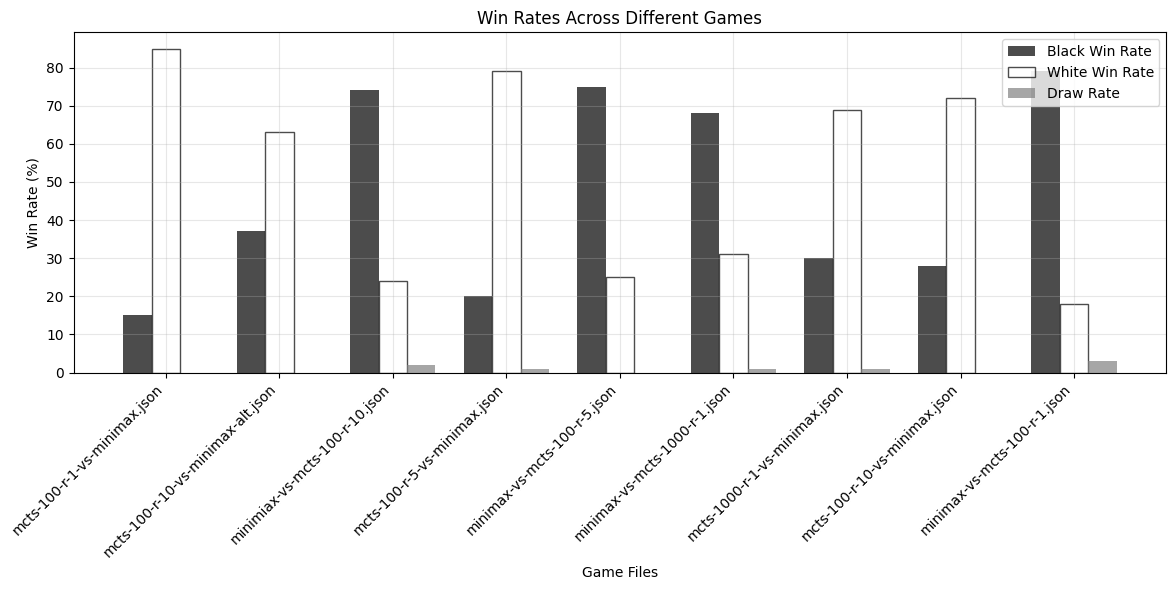

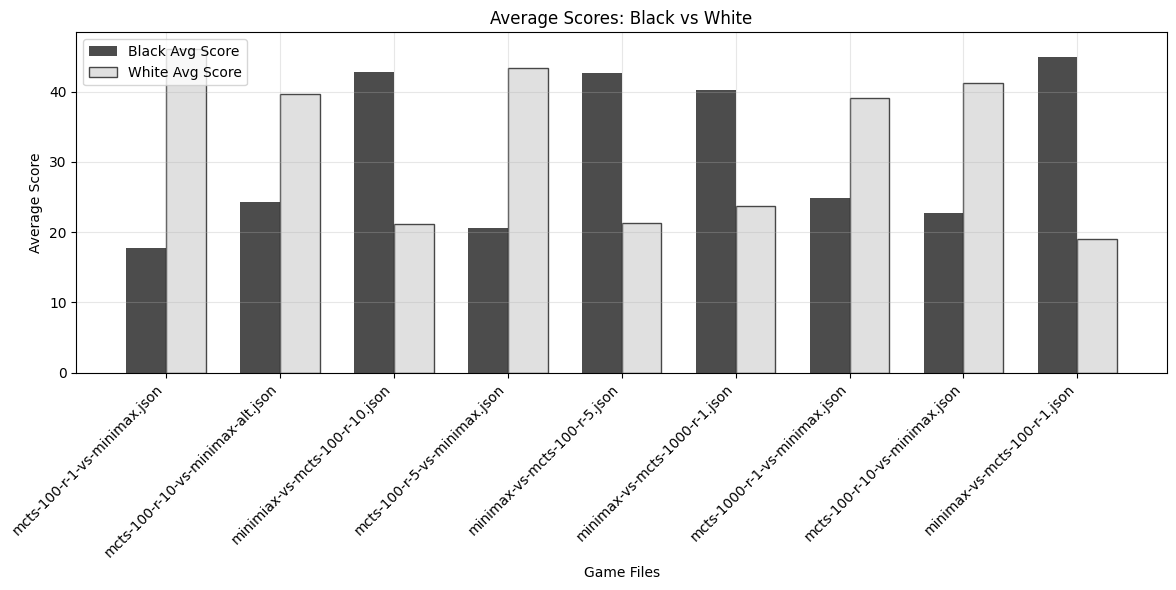

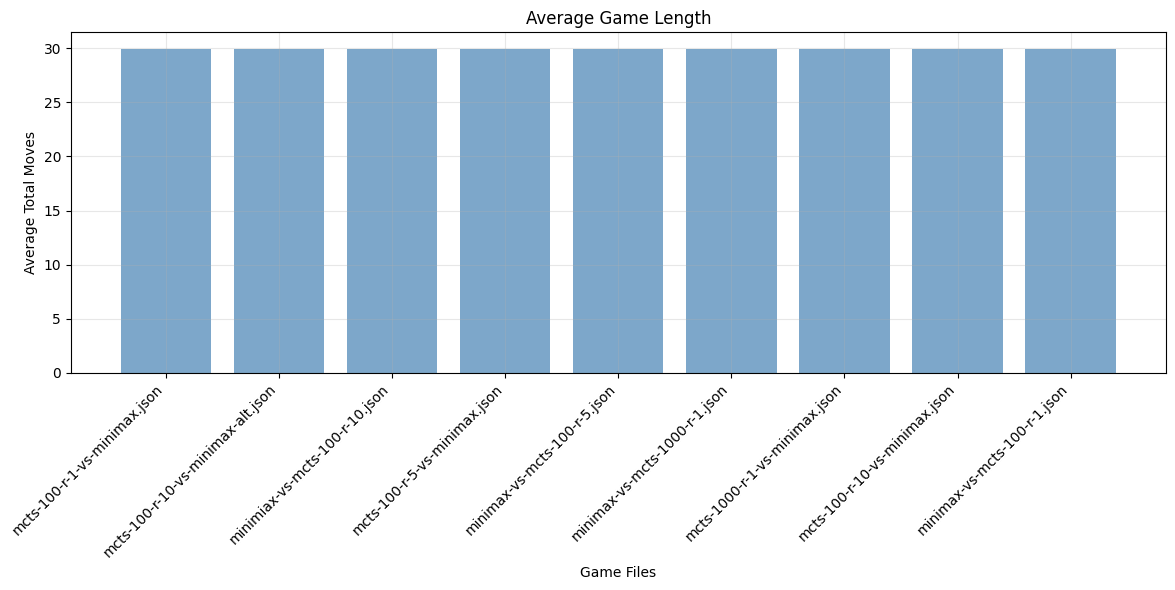

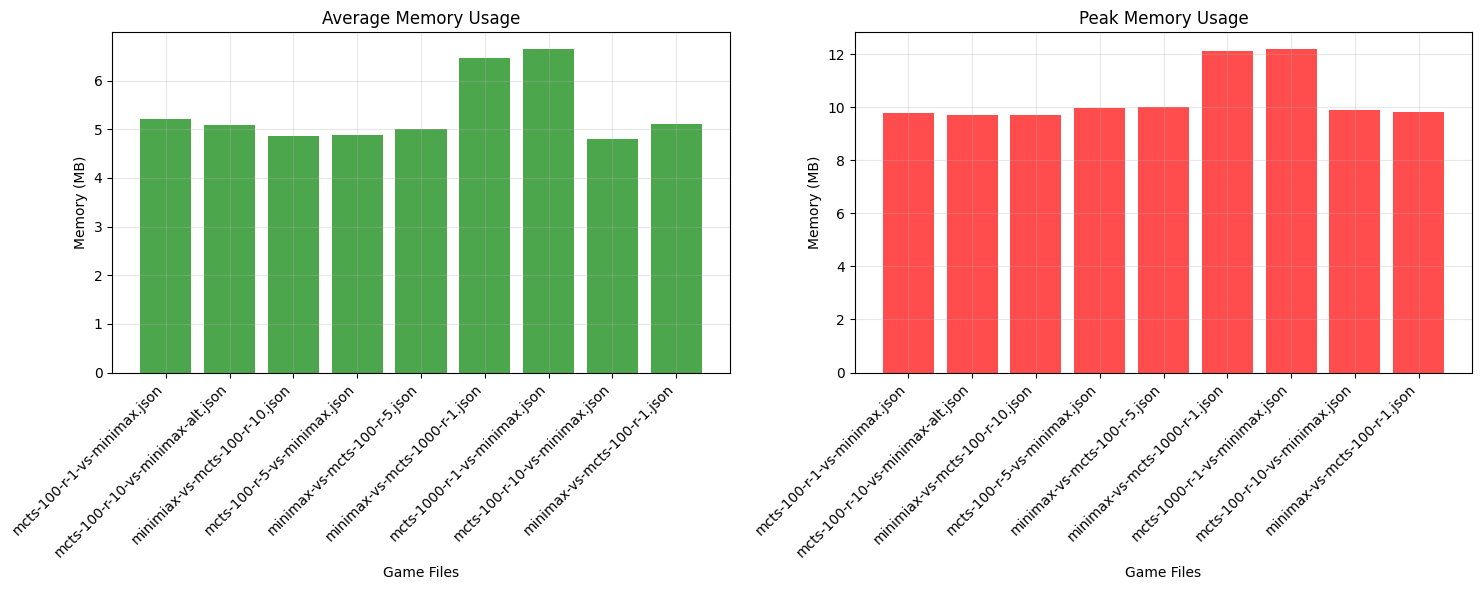

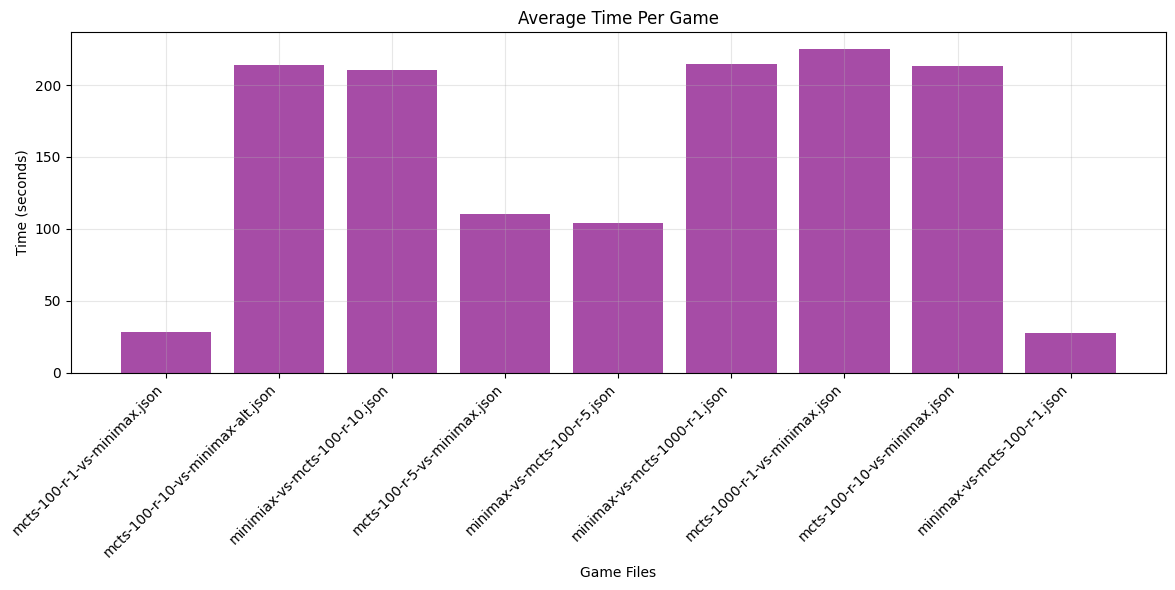

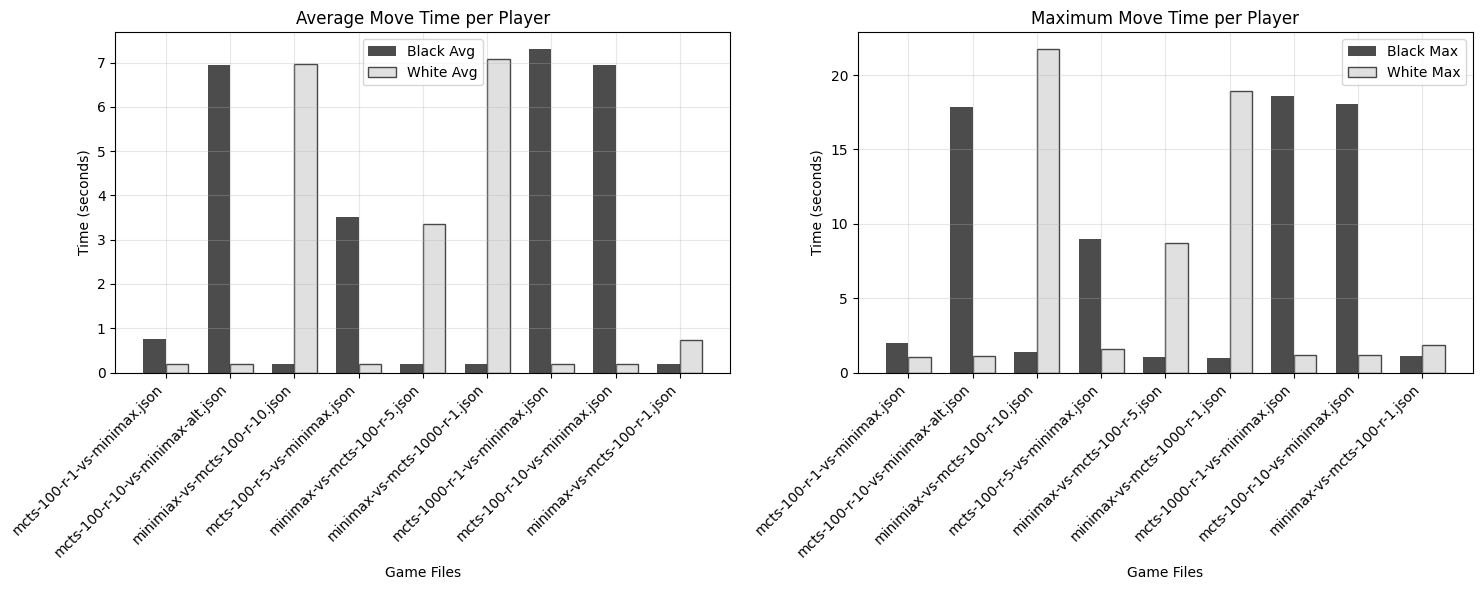

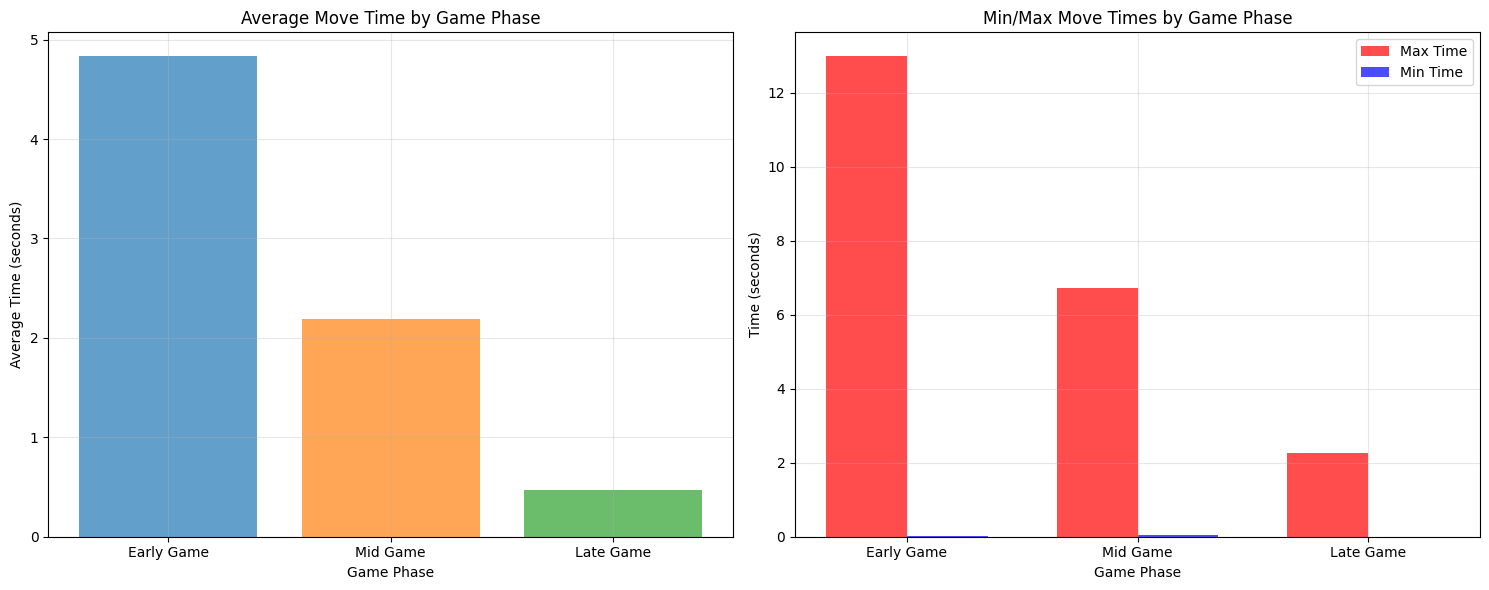

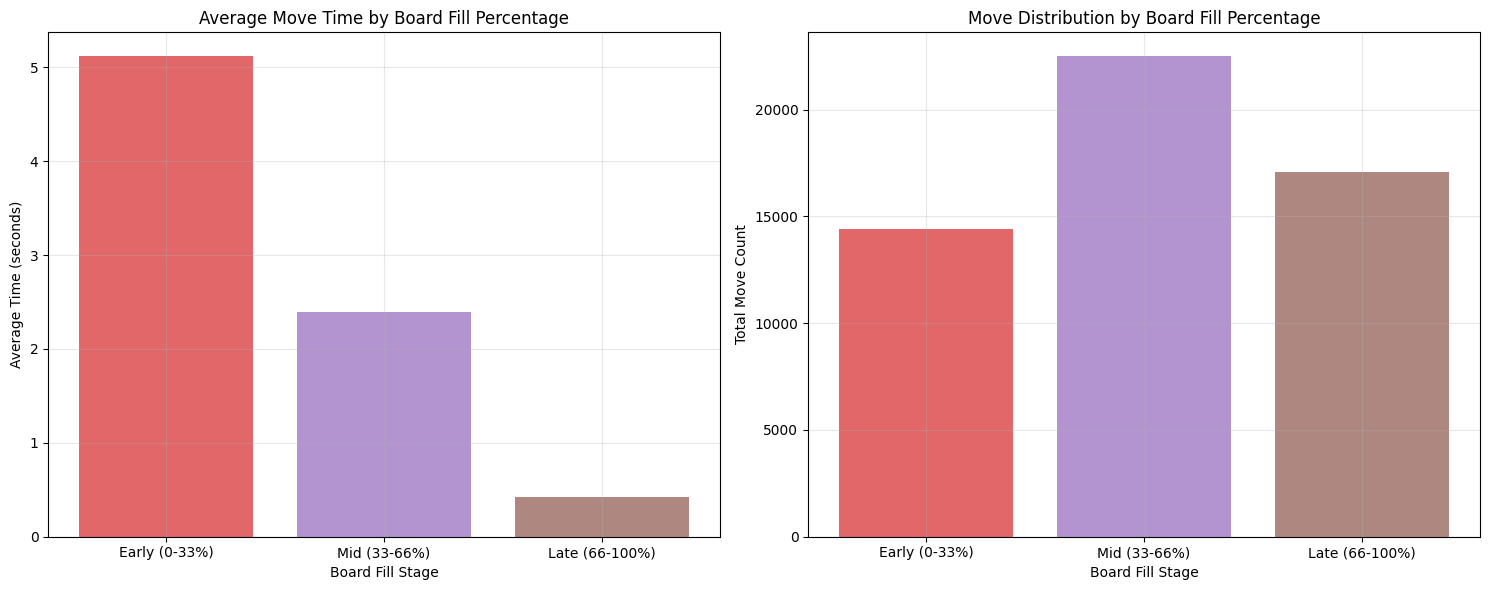

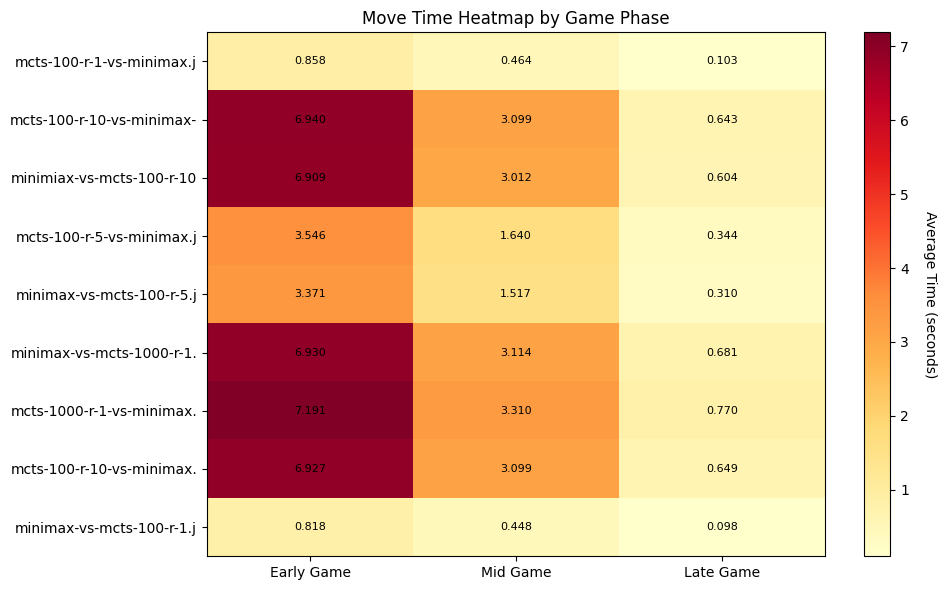

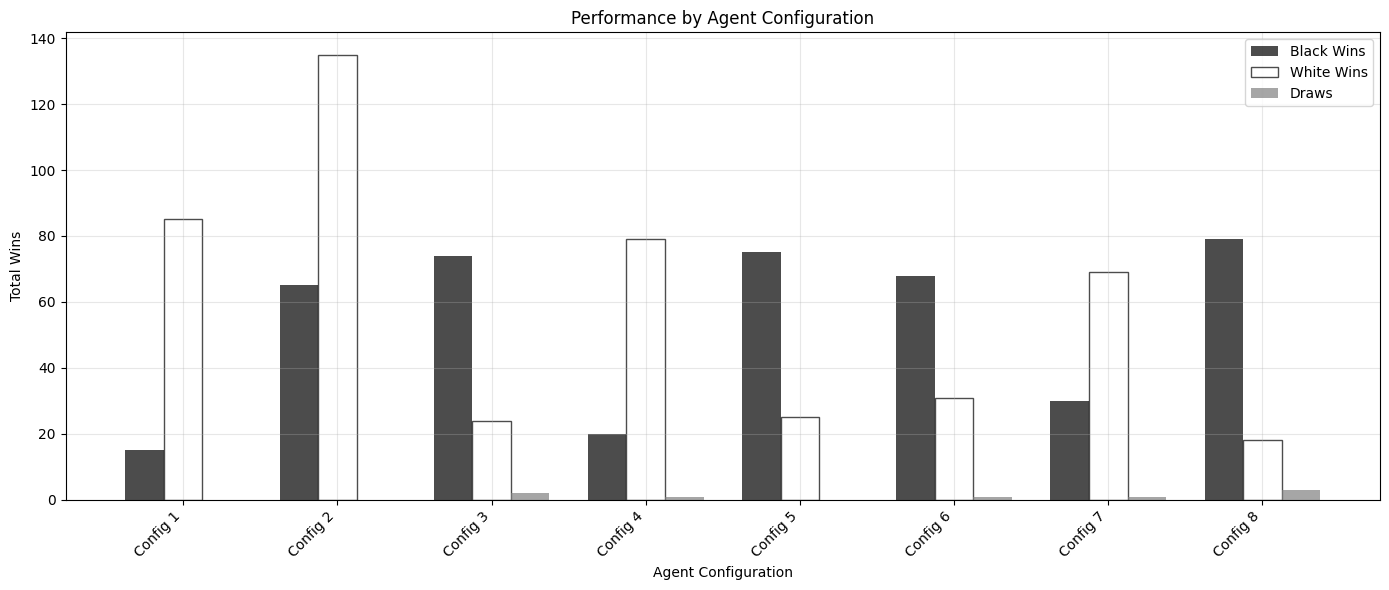

In [61]:
print("Loading data from:", DATA_DIR)
data_files = load_all_json_files(DATA_DIR)

if data_files:
    # Create all visualizations
    create_summary_table(data_files)
    plot_win_rates(data_files)
    plot_score_comparison(data_files)
    plot_game_length(data_files)
    plot_memory_usage(data_files)
    plot_time_per_game(data_files)
    plot_move_time_comparison(data_files)
    plot_timing_by_game_phase(data_files)
    plot_timing_by_board_fill(data_files)
    plot_combined_timing_heatmap(data_files)
    plot_agent_comparison(data_files)
else:
    print("No data files found. Please check the directory path.")

In [62]:
len(data_files)

9

In [63]:
mcts_start_data = []
minimax_start_data = []
for data in data_files:
    config = data.get('config', {})
    agents = config.get('agents', [])
    
    if len(agents) < 2:
        continue
    
    black_agent = agents[0]
    white_agent = agents[1]
    black_label = get_agent_label(black_agent)
    white_label = get_agent_label(white_agent)
    if black_label.startswith('mcts'):
        mcts_start_data.append(data)
    elif black_label.startswith('minimax'):
        minimax_start_data.append(data)

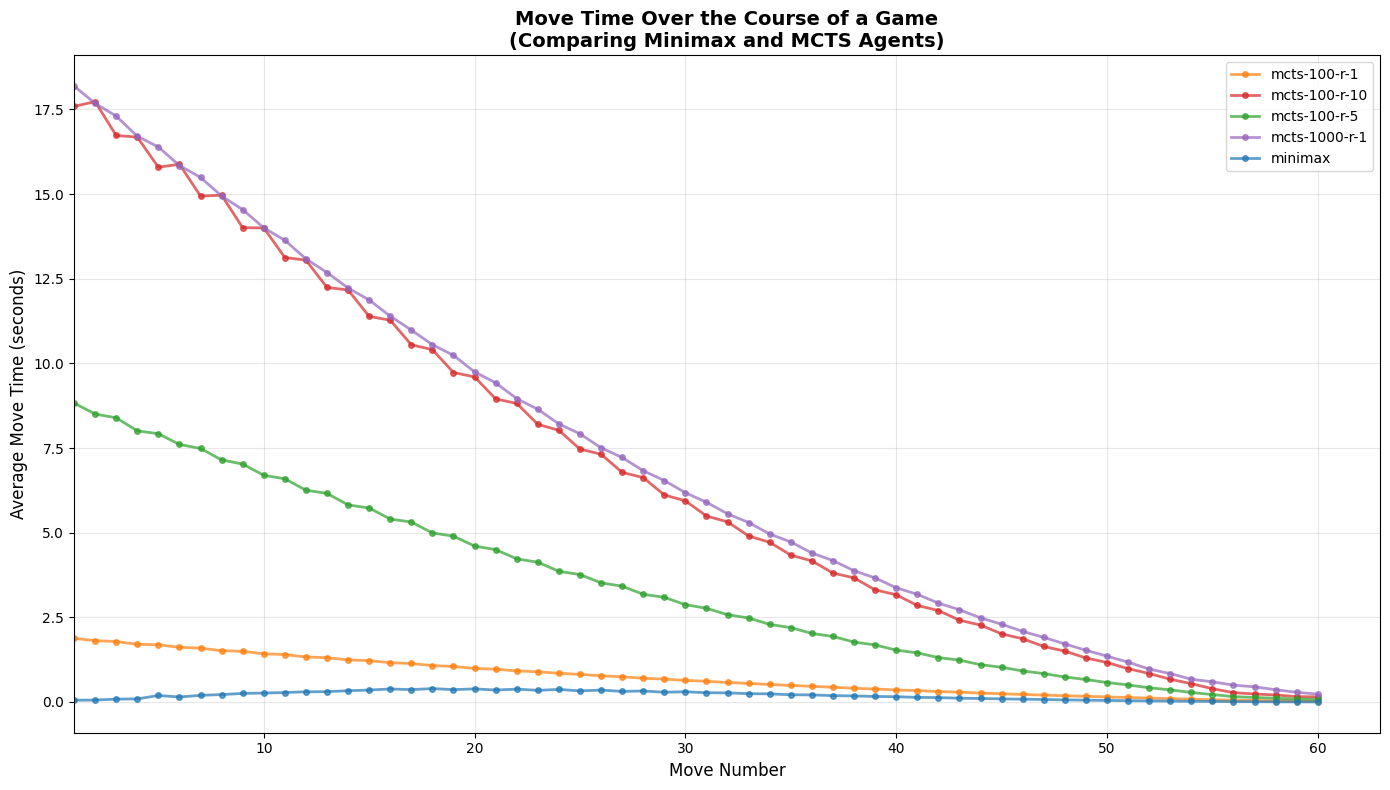

In [64]:
plot_move_time_over_game(data_files)

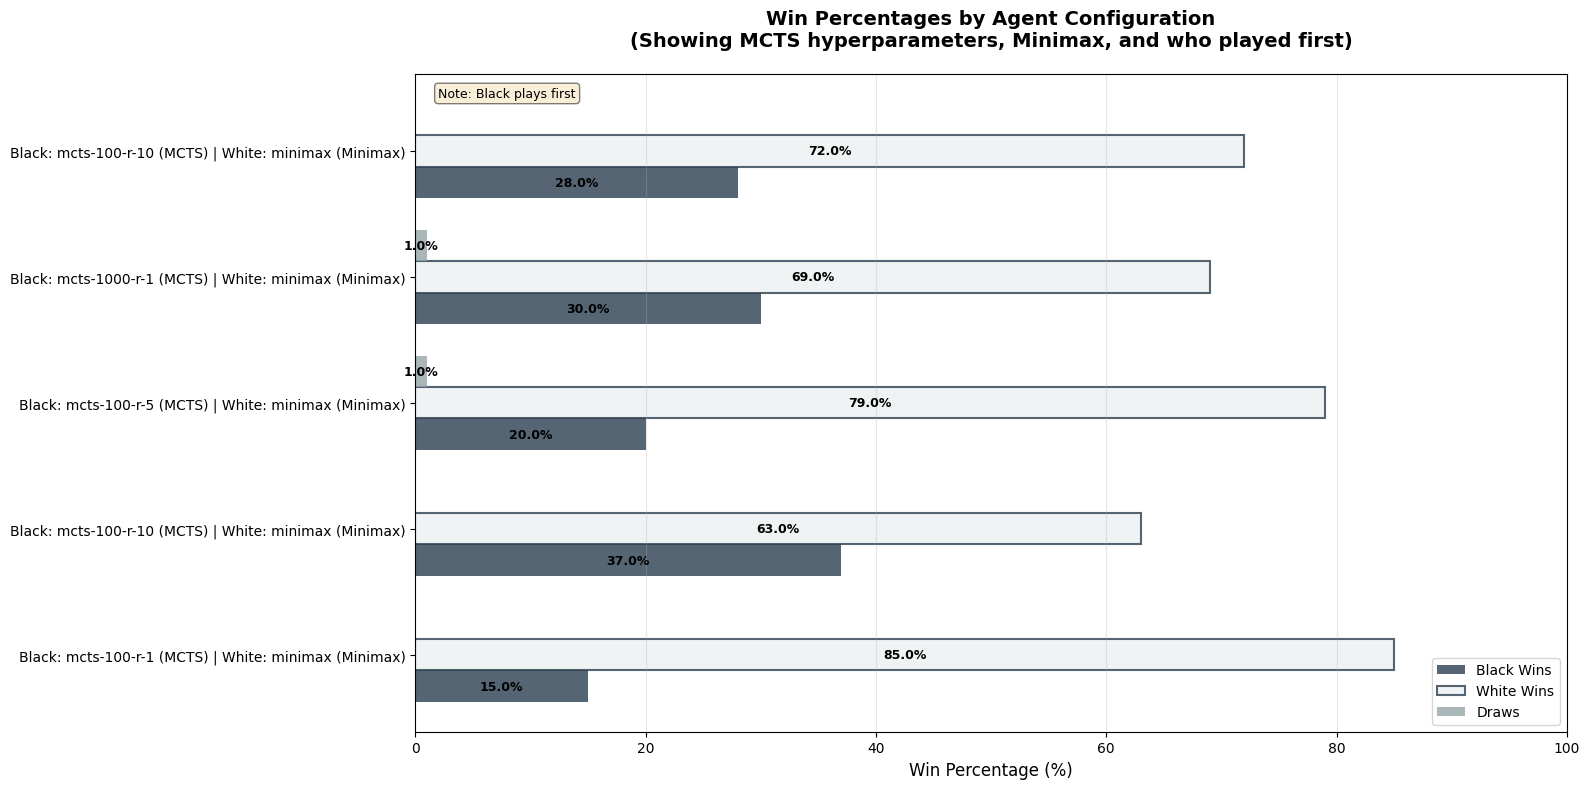

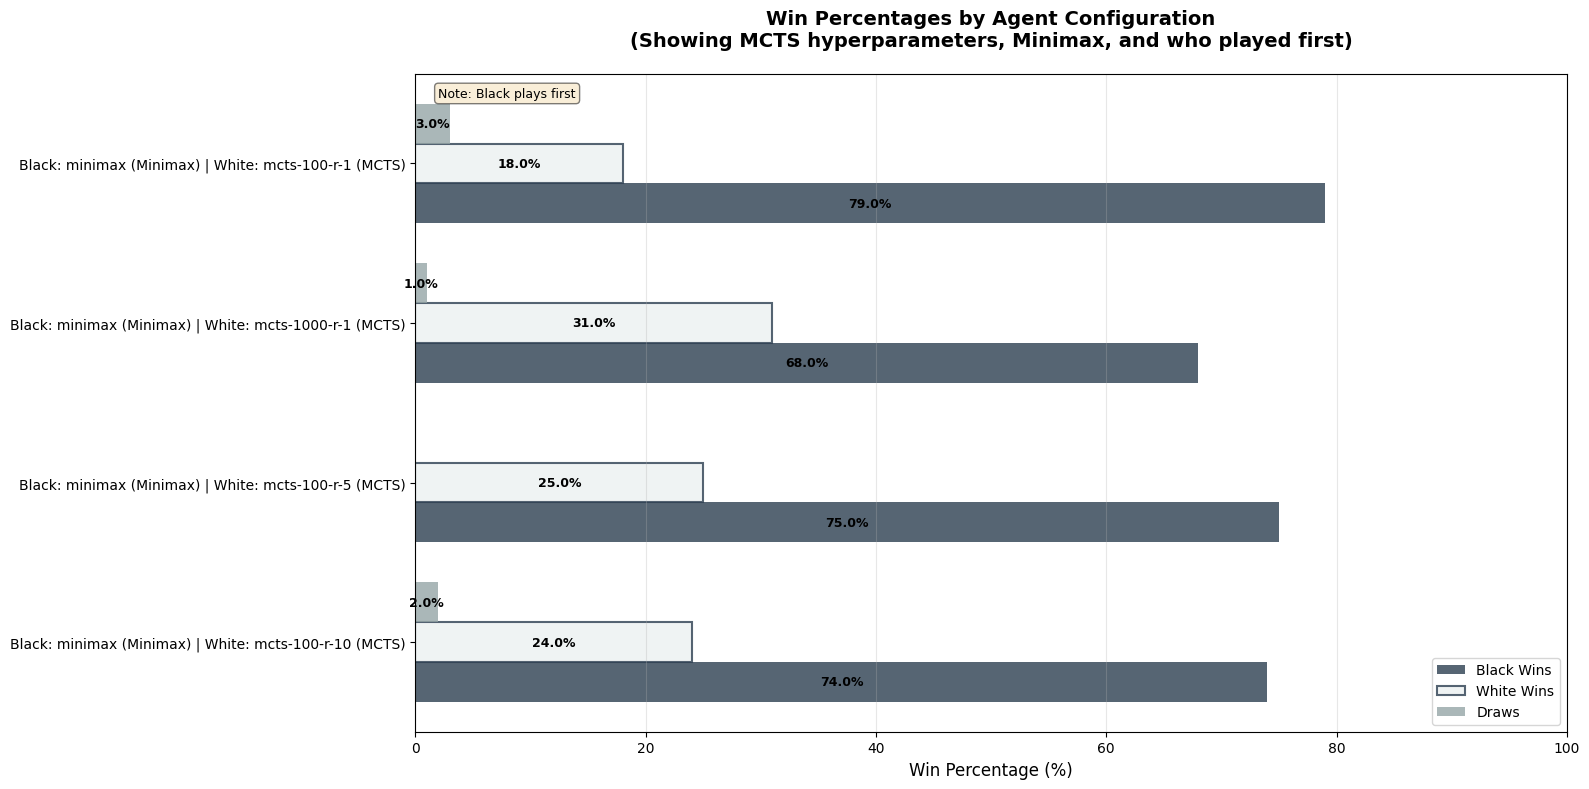

In [65]:
plot_win_percentages_by_configuration(mcts_start_data)
plot_win_percentages_by_configuration(minimax_start_data)

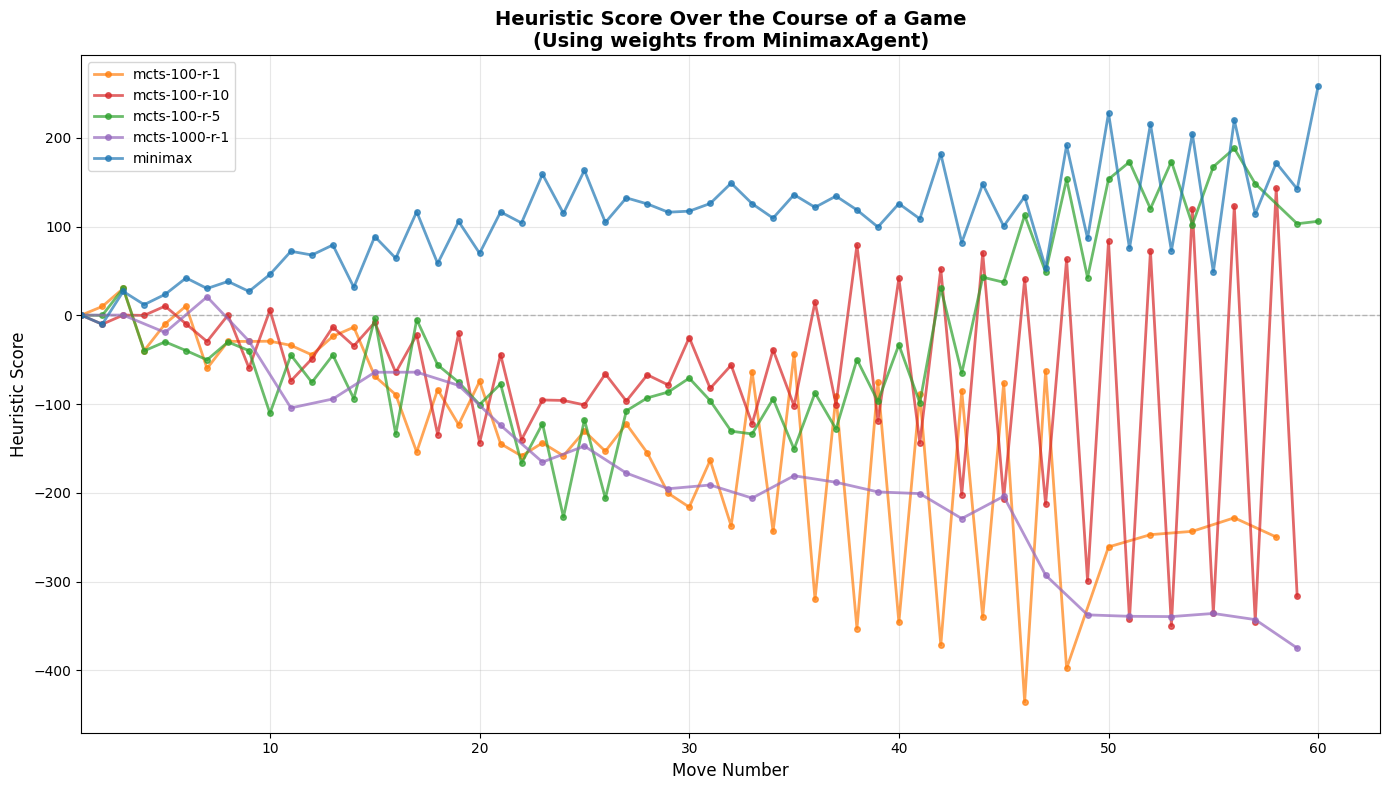

In [66]:
plot_heuristic_scores_over_game(data_files)

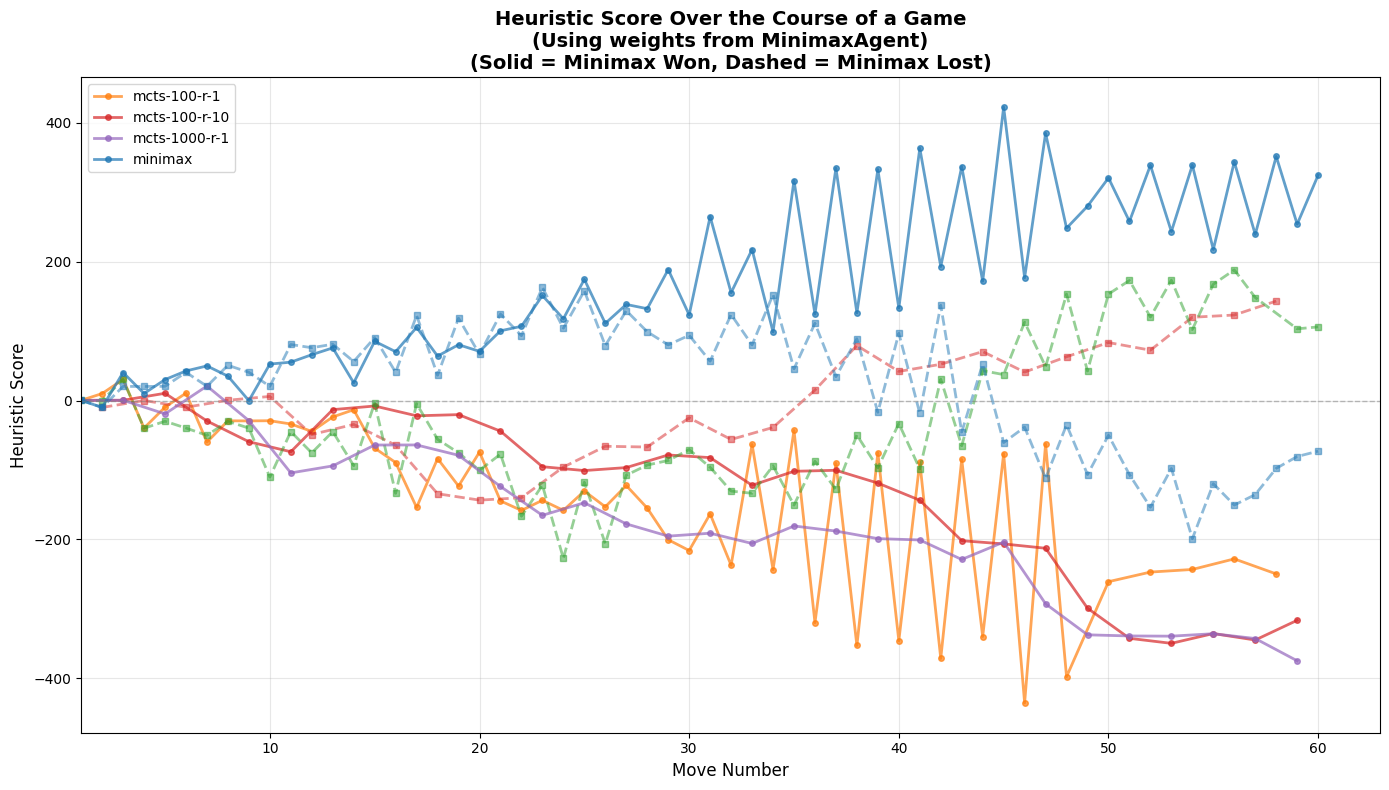

In [67]:
# Separated by minimax win/loss
plot_heuristic_scores_over_game(data_files, separate_by_minimax_result=True)